# Predicting Game Newsletter Subscription Using K-Nearest Neighbors

## Introduction
The purpose of this data science project is to analyze and predict player behaviours on a Minecraft server based on data collected by a UBC Computer Science research group. This data consisted of two primary files: players.csv and sessions.csv. The players.csv file included detailed information about each player, such as their age, experience level, email, and other personal traits. The sessions.csv file tracked individual play sessions for each player based on their email, including data on session times. 


### Research Question

**What player characteristics and behaviors are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?**

The specific question we addressed in this project is: "Can experience level, age, and total hours played predict newsletter subscription?"

By analyzing both the age and the experience level of a player, we will build a predictive model (K-NN Classification) to assess the likelihood of player subscribing to the newsletter based on such characteristics.


To answer this question, we focus solely on using the players.csv dataset file, as it includes the relevant characteristics (age and experience level) we will be using to hypothesize a player's subscription behaviour. This will involve exploring the dataset to understand the relationships between these variables and subscription status, followed by the development and assessment of the accuracy of our model to form predictions. 

This analysis uses techniques covered in the DSCI 100 course including data wrangling, visualization, and K-Nearest Neighbors classification.

### Dataset Description

The dataset contains 196 observations with the following variables:

- `experience`: Player experience level (Pro, Veteran, Regular, Amateur)
- `subscribe`: Whether the player subscribed to the newsletter
- `played_hours`: Total hours played
- `Age`: Player's age
- `gender`: Player's gender
- `hashedEmail` and `name`: Removed for irrelevance


**We selected the K-Nearest Neighbors (KNN) algorithm because it is non-parametric, easy to understand, and directly influenced by the similarity between features. This cooperates well with our small dataset and helps build an easy understanding of how different features impact prediction outcomes.**

**Because our predictors are categorical variables, we performed one-hot encoding to convert them into a numerical format to be used for the KNN algorithm.**

**Before modeling, we prepared the dataset as follows:**

- Removed unnecessary variables (name, hashedEmail)
- Removed rows with missing values using na.omit()



In [2]:
library(tidyverse)
library(class)
library(ggplot2)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 10)
library(recipes)
library(themis)
library(dplyr)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [13]:
# Reading players.csv file
url_player <- "https://drive.google.com/uc?id=1pD2UbBtMG1NHjlCo4HYVrvy72jilNUv-"
download.file(url_player, destfile = "players.csv")
players <- read_csv("players.csv") 

players_clean <- players |>
    select(-hashedEmail, -name) |>
    mutate(subscribe = as.factor(subscribe)) |>
    na.omit()


head(players_clean)


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,played_hours,gender,Age
<chr>,<fct>,<dbl>,<chr>,<dbl>
Pro,TRUE,30.3,Male,9
Veteran,TRUE,3.8,Male,17
Veteran,FALSE,0.0,Male,17
Amateur,TRUE,0.7,Female,21
Regular,TRUE,0.1,Male,21
Amateur,TRUE,0.0,Female,17


Upon inspecting the file, we observed that the number of subscribers exceeds the number of non-subscribers. To verify this, we created a table to compare the counts of each group. As shown below, 73% are subscribers, while 27% are non-subsribers. Given this class imbalance, we will upsample the response variable once we build the model to ensure a more balanced representation.

In [104]:
num_obs <- nrow(players)

players_subscribe <- players |>
  group_by(subscribe) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )

players_subscribe

subscribe,count,percentage
<lgl>,<int>,<dbl>
FALSE,52,26.53061
TRUE,144,73.46939


We then summarized numeric features to understand their scale and variance (e.g., max, min, mean).

In [4]:
players_clean |> 
  summarise(
    max_hours = max(played_hours),
    min_hours = min(played_hours),
    mean_hours = mean(played_hours),
    max_age = max(Age),
    min_age = min(Age),
    mean_age = mean(Age)
  )


max_hours,min_hours,mean_hours,max_age,min_age,mean_age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
223.1,0,5.904639,50,8,20.52062


### **Findings on Player Type Differences**  

We visualized three relationships:

- Subscription Rate by Experience Level

- Played Hours vs Subscription

- Age Distribution vs Subscription


Based on the visualizations generated, we can analyze the vary in characteristics and how these factors influence **subscription behaviour**.

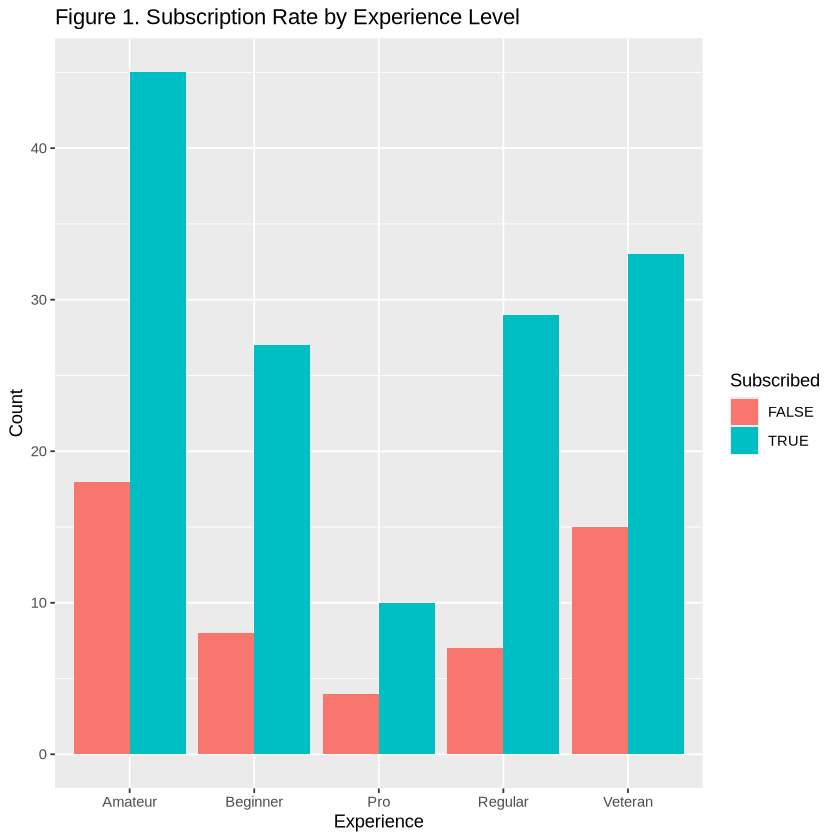

In [5]:
ggplot(players, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "dodge") +
  labs(title = "Figure 1. Subscription Rate by Experience Level", x = "Experience", y = "Count", fill = "Subscribed")


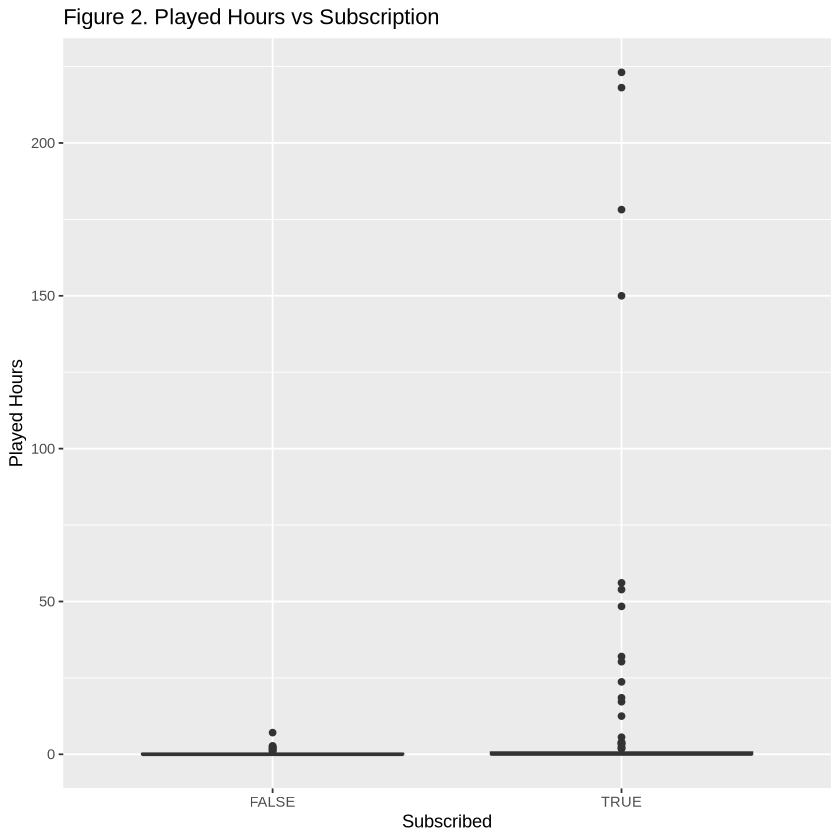

In [5]:
ggplot(players, aes(x = factor(subscribe), y = played_hours)) +
  geom_boxplot() +
  labs(
    title = "Figure 2. Played Hours vs Subscription",
    x = "Subscribed",
    y = "Played Hours"
  )


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


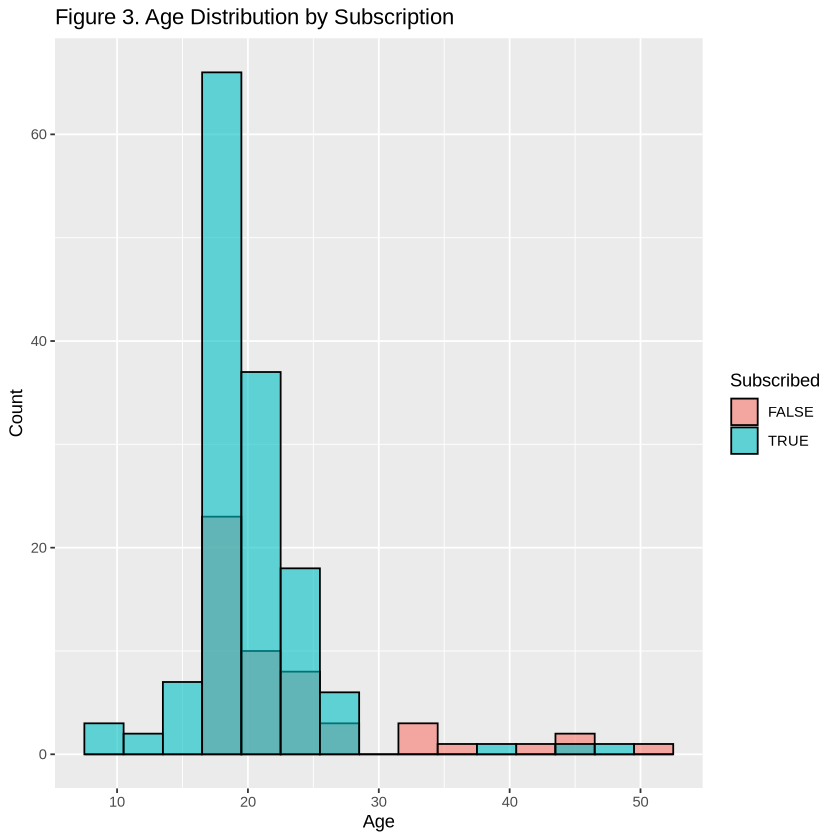

In [8]:
ggplot(players, aes(x = Age, fill = subscribe)) +
  geom_histogram(bins = 15, alpha = 0.6, position = "identity", color = "black") +
  labs(title = "Figure 3. Age Distribution by Subscription", x = "Age", y = "Count", fill = "Subscribed")

In [9]:
# ggplot(players, aes(x = gender, fill = factor(subscribe))) +
#   geom_bar(position = "fill") +
#   labs(
#     title = "Figure 4. Subscription Proportion by Gender",
#     x = "Gender",
#     y = "Proportion",
#     fill = "Subscribed"
#   )


#### **1 Experience Level vs Subscription Rate**
- Pro and Veteran players have the highest subscription rates, while Regular and Amateur players have lower subscription rates.

#### **2 Played Hours vs Subscription**
- Subscribed players tend to have higher median played hours.


#### **3 Age vs Subscription**
- Younger players are more likely to subscribe, at same time older players (above 30) show a lower subscription rate.

- Older players may focus on the playing alone


### **Methods & Results**  

To answer our question on whether the players' age, experience level, and played hours can predict the subscription of the player, the K-Nearest Neighbors (KNN) Classification model will be used. This method is appropriate because the target variable, `subscribe`, is logical (TRUE or FALSE). KNN is well-suited for binary classification tasks as it categorizes instances based on the majority class of their nearest neighbors in the feature space. It is also appropriate because KNN is a non-parametric method, meaning it does not make assumptions about the data distribution. Because KNN relies on distance metrics, we must scale the data. We must also be careful in our selection of k. Weaknesses and limitations may occur from the size of the data set, and any outliers that may be in the data set. To avoid overfitting or underfitting, we will apply cross-validation. Cross-validation helps ensure that the model is generalizing well to unseen data and is not just memorizing the training data. We will also experiment with different values of k to find the optimal number of neighbours, choosing the one that gives the highest cross-validated accuracy. The data will need to be split into training and testing sets, with a 70/30 split. Categorical variables will need to be encoded as numerical variables. All numerical features will be scaled to have a mean of 0 and a standard deviation of 1.




We first split the dataset into training and test sets using an 70/30 ratio using `initial_split()` function. 

In [6]:
set.seed(123)

players_split <- initial_split(players_clean, prop = 0.70, strata = subscribe)

players_train <- training(players_split)

players_test <- testing(players_split)

Then we create the recipe, ensuring to use the `scale()` function to normalize numerical predictors to ensure they are on comparable scales, which is essential for K-NN performance. 

As mentioned in the introduction, we also perform one-hot encoding through the `step_dummmy()` function to convert `experience` into numeric binary terms. Due to class imbalance (fewer non-subscribers than subscribers), we upsample the subscribe variable using `step_upsample()`. This will create a balanced dataset by replicating non-subscriber cases until both have equal representation. 

Finally, we define a K-NN specification model with `nearest_neighbor()` adding the defined recipe and with an initial guess of 3 neighbours which will later be tuned.

In [7]:
set.seed(3030) # DO NOT REMOVEz
players_recipe <- recipe(subscribe ~ Age + experience + played_hours, data = players_clean) |>
    step_dummy(experience, one_hot = TRUE) |> # To turn into numeric binary model terms
    step_upsample(subscribe, over_ratio = 1) |>  # To upsample subscribers : over_ratio = 1 means 1:1 ratio
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

players_recipe

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")




── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 3



── Operations 

• Dummy variables from: experience

• Up-sampling based on: subscribe

• Scaling for: all_predictors()

• Centering for: all_predictors()



To find the best k value, we can evaluate the accuracy of each k value by performing a 10-fold cross-validation split of our training data using `vfold_cv()` setting strata as our categorical label variable, `subscribe`. The new workflow we create is fit across all cross-validation folds through `fit_resamples()`, and we collect the aggregated performance metrics, quantifying how well our model performs across multiple validation runs.

Making a new K-NN specification, we make the number of neighbours as tunable through `tune()`, then create a grid of potential k values ranging from 1 to 40. Using `tune_grid()`, we evaluate each k value with our 10-fold cross-validation. After collecting all results, we filter the accuracy metrics and visualize the relationship between k and model accuracy, and the result was plotted as Figure 4, showing how model performance varies with K. This helps identify the value where accuracy peaks before overfitting or underfitting potentially occurs.

We then select the value of 26 as the best k value.

[1] 26

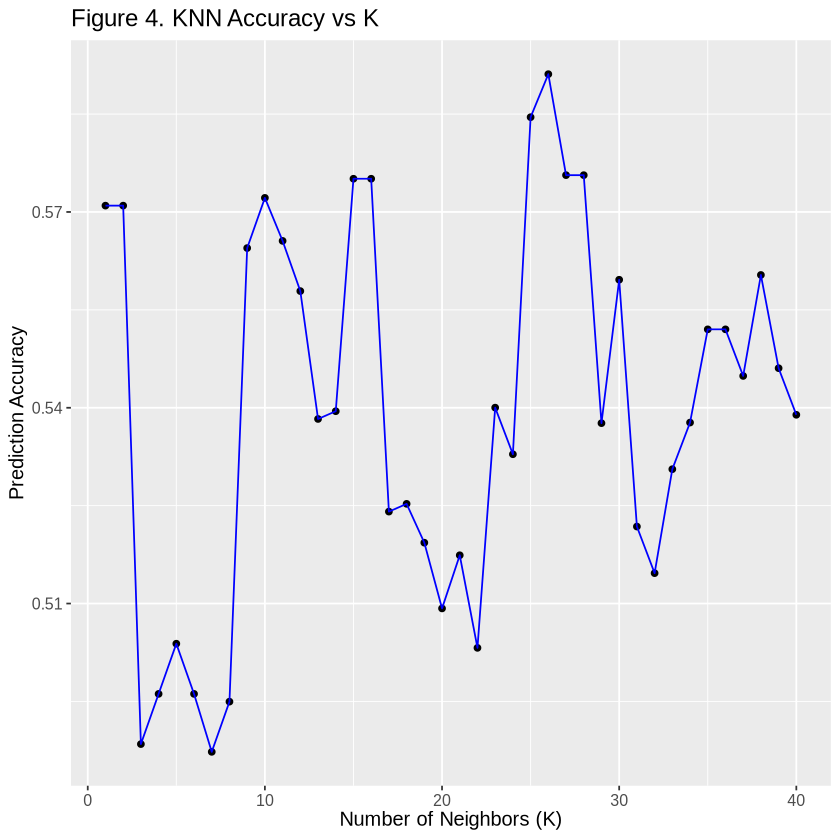

In [14]:
set.seed(1010) # DO NOT REMOVE


players_vfold <- vfold_cv(players_train, v = 10, strata = subscribe)

players_vfold_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    fit_resamples(resamples = players_vfold)


players_metrics <- collect_metrics(players_vfold_fit)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 40, by = 1))

knn_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line(color = "blue") +
  labs(
    title = "Figure 4. KNN Accuracy vs K",
    x = "Number of Neighbors (K)",
    y = "Prediction Accuracy"
  ) +
  theme(text = element_text(size = 12))

accuracy_vs_k

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

After identifying the optimal k value from above (`best_k`), we create a new K-NN specification model using this value. The model was combined with the previously preprocessed recipe in a new workflow, which was then fit to our entire training set (`players_train`) to create the final predictive model. 

In [9]:
set.seed(4040) # DO NOT REMOVE

# Creating model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_train)


Using our model, we generate predictions on our test set (`players_test`) to evaluate its performance on unseen data.

In [10]:
set.seed(2020) # DO NOT REMOVE

players_test_predictions <- predict(knn_fit, players_test) |>
  bind_cols(players_test)

#players_test_predictions 


Finally, we calculate the accuracy of our model by comparing it with the estimate of the response variable to the actual observation. We first compute the overall classification accuracy, which represents the proportion of correct predictions across all observations. We then examine precision, which measures how many of the predicted positive cases were actually positive. Then, we assess recall, which shows what proportion of actual positive cases our model successfully identified.

In [11]:
set.seed(2020) # DO NOT REMOVE

players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

players_test_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level="first")

players_test_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level="first")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7118644


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.4545455


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.3125


Given our model's suboptimal metrics (71% accuracy, 45% precision, and 31% recall), we conduct a deeper  examination using a confusion matrix to understand the specific patterns in prediction errors. The underlying factors as to why this is the case will be discussed in the limitations section of this project.

In [12]:
confusion <- players_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

          Truth
Prediction FALSE TRUE
     FALSE     5    6
     TRUE     11   37

## Discussion
**Figure 1: Subscription Rate by Experience Level**

Analysis:
The plot clearly shows that players with higher experience levels (Veteran and Pro) have higher subscription rates than Regular or Amateur players. This supports the assumption that more experienced players are more engaged with the game and thus more likely to subscribe. What's more, it may also reflect that experienced players have been in the game longer and had more possibility to see the newsletter option.

 **Figure 2: Played Hours vs Subscription (Boxplot)**

Analysis :
The boxplot indicates that subscribed players tend to have higher median and maximum playtime. This seems intuitive—more invested players may want to stay updated. However, it’s also possible that subscription leads to more engagement over time (reverse causality)

**Figure 3: Age Distribution by Subscription**

Analysis :
Younger players appear more likely to subscribe. This may reflect digital habits: Younger users tend to be more open to email subscriptions and more accustomed to in-game notifications and marketing. Oppositely, it may be that older users are less willing to opt into digital communications, or engage with subscriptions due to a preference for traditional media or lower familiarity with digital marketing.                                                         

**Predictive Model (Edit Later)**


Analysis:



These findings can help game developers better understand user behavior. For example, promotional efforts could be tailored to high-playtime players to increase conversions. Knowing that experience and age influence subscription likelihood, marketing emails could highlight tips, achievements, or community events to attract younger or more engaged players.Furthermore,The game team could also consider promoting newsletter subscriptions through platforms like Instagram and TikTok, which are more popular among younger audiences.

## Project Limitations and Improvements
After evaluating the KNN classification results (accuracy: 0.7119, precision: 0.4545, recall: 0.3125), we identified several reasons that likely affected the model’s performance. These issues can be grouped into six main parts:

**1. Data quality and consistency issues**: The dataset seems self-reported by players, thus, there are some inconsistencies. For example, some players are labeled as ”Veteran”, but their play hours is 0. Such contradictions indicate data entry errors. A possible solution is to set data filtering rules: ”Veteran” players must have at least 100 hours of game time.

**2. The model is sensitve to outliers**: Extreme values in variables such as played hours or age can interfere with KNN algorithms, which affect classification results.


**3. Insufficient Sample Size**: With only 196 players in the dataset, the sample may not be sufficiently representative of the overall player population. In particular, certain groups of people (e.g., older players, non-male genders, or very casual users) may be underrepresented, potentially biasing the model’s conclusions. Expanding the dataset with more diverse and balanced samples would improve the generalizability of the findings.

**4. Feature Limitation**: The model currently relies on a limited set of variables: age, experience, and total playtime. These features, while relevant, provide only a static snapshot of user behaviour. Incorporating dynamic behavioral indicators such as login frequency, session duration, recent activity, or interaction with in-game content could significantly enhance predictive power. Behavioural features often capture intent and engagement more effectively than static demographics.

**5. The current prediction ability is relatively weak**: Variables such as age, played hours, and experience level are not good predictors. These variables may have some correlation with subscription status, but there is no strong relationship. For instance, older players may be more likely to subscribe, but this does not mean that age directly causes subscription behaviour (reverse causality). Therefore, these variables may introduce noise in the model’s performance。


**6. Platform Bias**: The dataset does not capture which channels players encountered or accessed the subscription option. Players who engage primarily via mobile or social platforms might behave differently. Future data collection could include interaction channels to analyze cross-platform behavior differences.
According to the Ampere analysis’s data from Q3 of 2023, the content update strategies of various platforms vary: Netflix (mobile), Xbox, and PC have added a large number of games, while some console-based service platforms play a trend of decreasing players. This suggests that players on mobile platforms may be experiencing more dynamic content news (Ampere Analysis et al., 2023).


## References
Barbieri, F. M., & Malueg, D. A. (2008). Private provision of a discrete public good: Continuous‐strategy equilibria in the private‐information subscription   game. *Journal of Public Economic Theory, 10*(4), 703–727.<br>
https://doi.org/10.1111/j.1467-9779.2008.00378.x

Hu, M. (2022). Optimizing free-to-play multiplayer games with premium subscription (Master’s thesis, University of Michigan). *University of Michigan Deep Blue.*
https://hdl.handle.net/2027.42/171291
 
Statista. (2024, March). Number of titles added and removed by video game subscription services during Q3 2023[Graph]. *Statista*. <br>
https://www.statista.com/statistics/1429607/video-game-subscription-services-adding-or-removing-titles-q3-2023/
